In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ridge import RidgeRegression

In [187]:
#1- Data loading
ds = pd.read_csv('olympics_100m.csv', sep=',')

#Splitting traing/test
X = ds.loc[:,'Year'].values
y = ds.loc[:, 'Time'].values
X = X.reshape(len(ds),1)
y = y.reshape(len(ds),1)

#Split in training + validation and test  
#No shuffle since we have data ordered by time 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
   
#check the result obtained
print(X_train_val.shape)
print(y_train_val.shape)
print(X_test.shape)
print(y_test.shape)

(23, 1)
(23, 1)
(6, 1)
(6, 1)


## Performance of model without centering and normalizing data


In [188]:
#Validation phase performed with TimeSeriesSplit
k=5
kf = TimeSeriesSplit(n_splits=k)

#Lambda values to validate
lambda_values = np.array([((10 ** i)) for i in range(-10,4)])

mse_values = []
mse_avg = []

#Train a model for each lambda value and then perform cross validation, save mse values for each fold and then compute the average
for l in lambda_values:

    for i, (train_index, test_index) in enumerate(kf.split(X_train_val, y_train_val)):

        X_train, X_val = X_train_val[train_index], X_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]

        model = RidgeRegression(l, normalized=False)
        model.train(X_train,y_train)
        y_hat = model.predict(X_val)
        mse = model.MSE(y_hat,y_val)
        mse_values.append(mse)
        #print(f'Fold {i} - Lambda {l} - MSE {mse}')
        
    mse_avg.append(np.mean(mse_values))
    mse_values = []
        
#After having obtained all the average values for each lambda, since they are ordered, we search for the index of the minimum value, then we retrieve the best lambda
#print(f'MSE values: {mse_avg}')
min_mse = np.argmin(mse_avg)
#print(f'Min index MSE: {min_mse}')
lambda_best = lambda_values[min_mse]
print(f'Best lambda: {lambda_best}')



Best lambda: 1000.0


In [189]:
#Coarse to fine validation around the best lambda found, we proceeded with the same approach as before
mse_values = []
mse_avg = []

#The lambda values on which we perform validation are generated in a range around the best lambda found with step size equal to lambda_best*0.01
lambda_coarse_to_fine = np.arange(lambda_best/10, lambda_best*10, lambda_best*0.01)
for l in lambda_coarse_to_fine:

    for i, (train_index, test_index) in enumerate(kf.split(X_train_val)):

        X_train, X_val = X_train_val[train_index], X_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]

        model = RidgeRegression(l, normalized=False)
        model.train(X_train,y_train)
        y_hat = model.predict(X_val)
        mse = model.MSE(y_hat,y_val)
        mse_values.append(mse)
        #print(f'Fold {i} - Lambda {l} - MSE {mse}')
        
    mse_avg.append(np.mean(mse_values))
    mse_values = []

#print(f'MSE values: {mse_avg}')
min_mse = np.argmin(mse_avg)
#print(f'Min index MSE: {min_mse}')
lambda_best = lambda_coarse_to_fine[min_mse]
print(f'Best lambda: {lambda_best}')

Best lambda: 960.0


In [190]:
#Performance of our model
model = RidgeRegression(lambda_best)
model.train(X_train_val,y_train_val)
print(f' Weights:' + str(model.weights))
y_hat = model.predict(X_test)
model.MSE(y_hat,y_test)

print(f'MSE: {model.MSE(y_hat,y_test)}')

 Weights:[[ 3.60999571e+01]
 [-1.31790565e-02]]
MSE: 0.0381144630879367


In [191]:
#Performance of Scikit model
RidgeModel = Ridge(alpha=lambda_best, fit_intercept=True)
RidgeModel.fit(X_train_val,y_train_val)
print(f'Intercept:' + str(RidgeModel.intercept_))
print(f' Weights:' + str(RidgeModel.coef_))
y_hat_sk = RidgeModel.predict(X_test)

print(f'MSE (scikit): {mean_squared_error(y_test,y_hat_sk)}')

Intercept:[36.09995711]
 Weights:[[-0.01317906]]
MSE (scikit): 0.03811446308614535


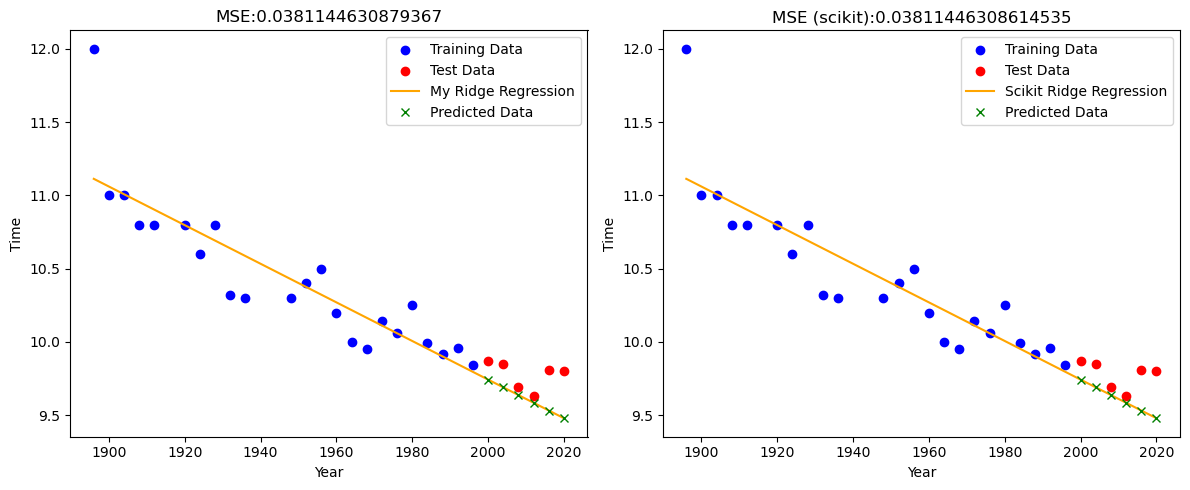

In [192]:
#We will plot the data in 2 subplot to see the difference between our model and the scikit model

#Creating transformed data
X_train_val_poly = PolynomialFeatures(1).fit_transform(X_train_val)
X_test_poly = PolynomialFeatures(1).fit_transform(X_test)   

#Setting size of the figure
plt.figure(figsize=(12,5))

#Starting from our model in the first sub-plot
plt.subplot(1,2,1)

#Plotting training data and test data in different colors
plt.scatter(X_train_val_poly[:, 1], y_train_val, color='blue', label='Training Data')
plt.scatter(X_test_poly[:, 1], y_test, color='red', label='Test Data')

#Predicting the values of our model with best lambda over all the dataset
model = RidgeRegression(lambda_best)
model.train(X_train_val,y_train_val)
y_hat_plot = model.predict(X)

#Plot of our model with best lambda
plt.plot(X[:,0], y_hat_plot, label='My Ridge Regression', color='orange')

#Plotting our model prediction
plt.plot(X_test_poly[:,1],y_hat,'x', label='Predicted Data', color='green')

plt.title('MSE:' + str(model.MSE(y_hat,y_test)))
plt.xlabel('Year')
plt.ylabel('Time')
plt.legend()



#Now we plot the scikit model in the second sub-plot
plt.subplot(1,2,2)

# Plotting training data and test data in different colors
plt.scatter(X_train_val_poly[:, 1], y_train_val, color='blue', label='Training Data')
plt.scatter(X_test_poly[:, 1], y_test, color='red', label='Test Data')


#Predicting the values of sk model with best lambda over all the dataset
ridge = Ridge(alpha=lambda_best, fit_intercept=True)
ridge.fit(X_train_val,y_train_val)
y_hat_sk_plot = ridge.predict(X)

#Plot of sk model
plt.plot(X[:,0], y_hat_sk_plot, label='Scikit Ridge Regression', color='orange')
plt.plot(X_test_poly[:,1],y_hat_sk,'x', label='Predicted Data', color='green')

plt.title('MSE (scikit):' + str(mean_squared_error(y_test,y_hat_sk)))
plt.xlabel('Year')
plt.ylabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

## Performance of the model centering and normalizing data

In [193]:
#Validation phase performed with TimeSeriesSplit
k=5
kf = TimeSeriesSplit(n_splits=k)

#Lambda values to validate
lambda_values = np.array([((10 ** i)) for i in range(-10,4)])

mse_values = []
mse_avg = []

#Train a model for each lambda value and then perform cross validation, save mse values for each fold and then compute the average
for l in lambda_values:

    for i, (train_index, test_index) in enumerate(kf.split(X_train_val, y_train_val)):

        X_train, X_val = X_train_val[train_index], X_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]

        model = RidgeRegression(l, normalized=True)
        model.train(X_train,y_train)
        y_hat = model.predict(X_val)
        mse = model.MSE(y_hat,y_val)
        mse_values.append(mse)
        #print(f'Fold {i} - Lambda {l} - MSE {mse}')
        
    mse_avg.append(np.mean(mse_values))
    mse_values = []
        
#After having obtained all the average values for each lambda, since they are ordered, we search for the index of the minimum value, then we retrieve the best lambda
#print(f'MSE values: {mse_avg}')
min_mse = np.argmin(mse_avg)
#print(f'Min index MSE: {min_mse}')
lambda_best = lambda_values[min_mse]
print(f'Best lambda: {lambda_best}')

Best lambda: 10.0


In [194]:
#Coarse to fine validation around the best lambda found, we proceeded with the same approach as before
mse_values = []
mse_avg = []

#The lambda values on which we perform validation are generated in a range around the best lambda found with step size equal to lambda_best*0.01
lambda_coarse_to_fine = np.arange(lambda_best/10, lambda_best*10, lambda_best*0.01)
for l in lambda_coarse_to_fine:

    for i, (train_index, test_index) in enumerate(kf.split(X_train_val)):

        X_train, X_val = X_train_val[train_index], X_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]

        model = RidgeRegression(l, normalized=True)
        model.train(X_train,y_train)
        y_hat = model.predict(X_val)
        mse = model.MSE(y_hat,y_val)
        mse_values.append(mse)
        #print(f'Fold {i} - Lambda {l} - MSE {mse}')
        
    mse_avg.append(np.mean(mse_values))
    mse_values = []

#print(f'MSE values: {mse_avg}')
min_mse = np.argmin(mse_avg)
#print(f'Min index MSE: {min_mse}')
lambda_best = lambda_coarse_to_fine[min_mse]
print(f'Best lambda: {lambda_best}')

Best lambda: 4.800000000000003


In [195]:
#Performance of our model
model = RidgeRegression(lambda_best, normalized=True)
model.train(X_train_val,y_train_val)
print(f' Weights:' + str(model.weights))
y_hat = model.predict(X_test)
model.MSE(y_hat,y_test)

print(f'MSE: {model.MSE(y_hat,y_test)}')

 Weights:[[-6.83481050e-16]
 [-3.54835866e-01]]
MSE: 0.012200477003864731


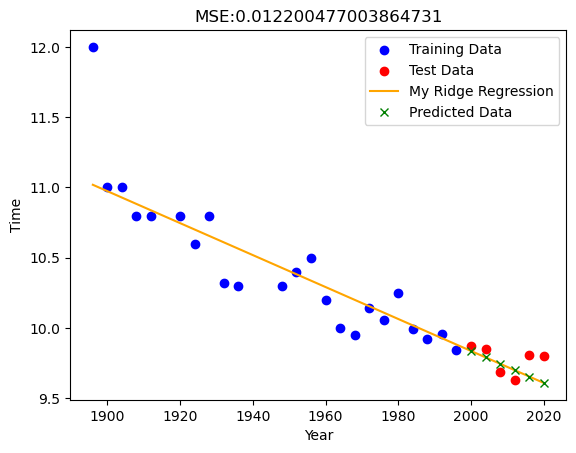

In [196]:
#We will plot the data in 2 subplot to see the difference between our model and the scikit model

#Creating transformed data
X_train_val_poly = PolynomialFeatures(1).fit_transform(X_train_val)
X_test_poly = PolynomialFeatures(1).fit_transform(X_test)   

#Plotting training data and test data in different colors
plt.scatter(X_train_val_poly[:, 1], y_train_val, color='blue', label='Training Data')
plt.scatter(X_test_poly[:, 1], y_test, color='red', label='Test Data')

#Predicting the values of our model with best lambda over all the dataset
model = RidgeRegression(lambda_best, normalized=True)
model.train(X_train_val,y_train_val)
y_hat_plot = model.predict(X)

#Plot of our model with best lambda
plt.plot(X[:,0], y_hat_plot, label='My Ridge Regression', color='orange')

#Plotting our model prediction
plt.plot(X_test_poly[:,1],y_hat,'x', label='Predicted Data', color='green')

plt.title('MSE:' + str(model.MSE(y_hat,y_test)))
plt.xlabel('Year')
plt.ylabel('Time')
plt.legend()



plt.show()